# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

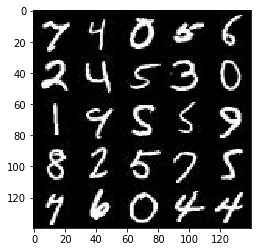

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

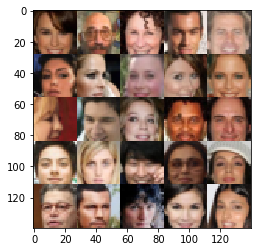

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return (input_images, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    kernel_init = tf.contrib.layers.xavier_initializer()


    with tf.variable_scope("discriminator", reuse=reuse):

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=kernel_init)
        relu1 = tf.maximum(alpha*conv1, conv1)
        drop1 = tf.nn.dropout(relu1, keep_prob=0.7)
        
        conv2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding="same")
        relu2 = tf.maximum(alpha*conv2, conv2)
        drop2 = tf.nn.dropout(relu2, keep_prob=0.7)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding="same")
        relu3 = tf.maximum(alpha*conv3, conv3)
        drop3 = tf.nn.dropout(relu3, keep_prob=0.7)
        
        conv4 = tf.layers.conv2d(drop3, 512, 5, strides=2, padding="same")
        normalization = tf.layers.batch_normalization(conv4, training=True)
        relu4 = tf.maximum(alpha*normalization, normalization)
        drop4 = tf.nn.dropout(relu4, keep_prob=0.7)
        
        flat = tf.reshape(drop4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1

    with tf.variable_scope("generator", reuse= not is_train):

        fullyConLayer = tf.layers.dense(z, 7*7*512)
        fullyConLayer = tf.reshape(fullyConLayer, (-1, 7, 7, 512))
        
        # leaky ReLU
        relu1 = tf.maximum(alpha*fullyConLayer, fullyConLayer)
        drop1 = tf.nn.dropout(relu1, keep_prob=0.5)
        
        conv2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding="same")
        relu2 = tf.maximum(alpha*conv2, conv2)
        drop2 = tf.nn.dropout(relu2, keep_prob=0.5)
        
        conv3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding="same")
        relu3 = tf.maximum(alpha*conv3, conv3)
        drop3 = tf.nn.dropout(relu3, keep_prob=0.5)
        
        conv4 = tf.layers.conv2d_transpose(drop3, 64, 5, strides=1, padding="same")
        normalization = tf.layers.batch_normalization(conv4, training=is_train)
        relu4 = tf.maximum(alpha*normalization, normalization)
        drop4 = tf.nn.dropout(relu4, keep_prob=0.5)
        
        logits = tf.layers.conv2d_transpose(drop4, out_channel_dim, 5, strides=1, padding="same")
        output = tf.tanh(logits)
        
    return output





"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Smoothing 
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs( data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                """ 
                Run the optimization for the generator twice to make sure 
                that the discriminator loss does not go to zero 
                """
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess,25, input_z, data_shape[3], data_image_mode)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.2553... Generator Loss: 2.0237
Epoch 0/2... Discriminator Loss: 1.2627... Generator Loss: 0.7228
Epoch 0/2... Discriminator Loss: 1.3012... Generator Loss: 1.0594
Epoch 0/2... Discriminator Loss: 0.6432... Generator Loss: 2.1729
Epoch 0/2... Discriminator Loss: 1.6920... Generator Loss: 0.9048
Epoch 0/2... Discriminator Loss: 0.4428... Generator Loss: 3.0710
Epoch 0/2... Discriminator Loss: 0.4079... Generator Loss: 3.9187
Epoch 0/2... Discriminator Loss: 0.8948... Generator Loss: 1.0071
Epoch 0/2... Discriminator Loss: 1.0909... Generator Loss: 1.0149
Epoch 0/2... Discriminator Loss: 2.3528... Generator Loss: 0.2923


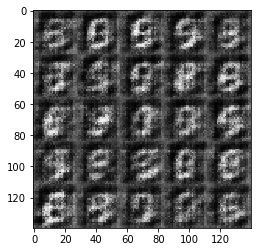

Epoch 0/2... Discriminator Loss: 1.1836... Generator Loss: 1.4014
Epoch 0/2... Discriminator Loss: 1.0329... Generator Loss: 1.4319
Epoch 0/2... Discriminator Loss: 1.7872... Generator Loss: 1.0471
Epoch 0/2... Discriminator Loss: 1.3468... Generator Loss: 1.2282
Epoch 0/2... Discriminator Loss: 1.7565... Generator Loss: 0.8164
Epoch 0/2... Discriminator Loss: 1.0821... Generator Loss: 1.3666
Epoch 0/2... Discriminator Loss: 1.2015... Generator Loss: 1.6285
Epoch 0/2... Discriminator Loss: 1.2845... Generator Loss: 0.6760
Epoch 0/2... Discriminator Loss: 1.3505... Generator Loss: 1.3683
Epoch 0/2... Discriminator Loss: 1.2600... Generator Loss: 0.8894


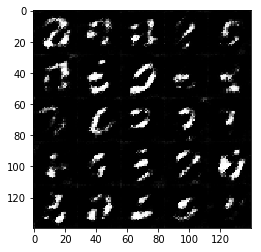

Epoch 0/2... Discriminator Loss: 1.0612... Generator Loss: 0.8122
Epoch 0/2... Discriminator Loss: 1.2235... Generator Loss: 0.6745
Epoch 0/2... Discriminator Loss: 1.4089... Generator Loss: 0.9028
Epoch 0/2... Discriminator Loss: 1.2073... Generator Loss: 1.1819
Epoch 0/2... Discriminator Loss: 1.3119... Generator Loss: 0.8302
Epoch 0/2... Discriminator Loss: 1.2171... Generator Loss: 0.7188
Epoch 0/2... Discriminator Loss: 1.0067... Generator Loss: 1.1141
Epoch 0/2... Discriminator Loss: 1.1693... Generator Loss: 1.1226
Epoch 0/2... Discriminator Loss: 1.4015... Generator Loss: 0.8619
Epoch 0/2... Discriminator Loss: 1.1020... Generator Loss: 1.0167


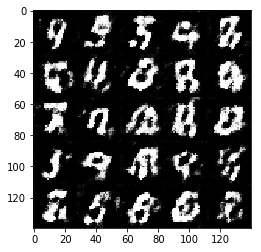

Epoch 0/2... Discriminator Loss: 1.1169... Generator Loss: 1.3323
Epoch 0/2... Discriminator Loss: 1.3857... Generator Loss: 0.7046
Epoch 0/2... Discriminator Loss: 1.2929... Generator Loss: 1.1171
Epoch 0/2... Discriminator Loss: 0.9863... Generator Loss: 1.4360
Epoch 0/2... Discriminator Loss: 1.1931... Generator Loss: 1.0643
Epoch 0/2... Discriminator Loss: 1.1479... Generator Loss: 1.2654
Epoch 0/2... Discriminator Loss: 1.3406... Generator Loss: 1.4408
Epoch 0/2... Discriminator Loss: 1.0821... Generator Loss: 0.8562
Epoch 0/2... Discriminator Loss: 0.8858... Generator Loss: 1.2561
Epoch 0/2... Discriminator Loss: 1.0722... Generator Loss: 1.2117


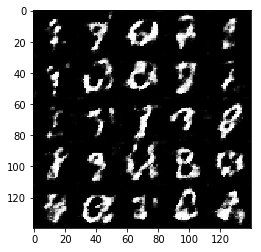

Epoch 0/2... Discriminator Loss: 0.8647... Generator Loss: 1.8897
Epoch 0/2... Discriminator Loss: 1.0698... Generator Loss: 1.4195
Epoch 0/2... Discriminator Loss: 0.9936... Generator Loss: 1.4014
Epoch 0/2... Discriminator Loss: 1.3022... Generator Loss: 1.5016
Epoch 0/2... Discriminator Loss: 0.9695... Generator Loss: 1.0077
Epoch 0/2... Discriminator Loss: 0.8674... Generator Loss: 1.2926
Epoch 0/2... Discriminator Loss: 1.2975... Generator Loss: 0.6078
Epoch 0/2... Discriminator Loss: 1.2025... Generator Loss: 0.8780
Epoch 0/2... Discriminator Loss: 0.9532... Generator Loss: 1.1162
Epoch 0/2... Discriminator Loss: 0.9104... Generator Loss: 1.6606


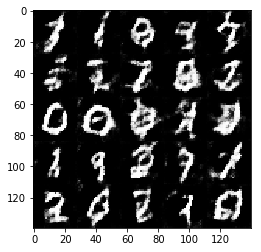

Epoch 0/2... Discriminator Loss: 1.1434... Generator Loss: 2.0337
Epoch 0/2... Discriminator Loss: 1.0599... Generator Loss: 0.4077
Epoch 0/2... Discriminator Loss: 0.9378... Generator Loss: 1.1007
Epoch 0/2... Discriminator Loss: 0.9212... Generator Loss: 1.0892
Epoch 0/2... Discriminator Loss: 1.1522... Generator Loss: 1.1106
Epoch 0/2... Discriminator Loss: 1.1319... Generator Loss: 1.2226
Epoch 0/2... Discriminator Loss: 0.9164... Generator Loss: 0.9961
Epoch 0/2... Discriminator Loss: 0.9254... Generator Loss: 1.5689
Epoch 0/2... Discriminator Loss: 1.1931... Generator Loss: 1.1368
Epoch 0/2... Discriminator Loss: 1.2530... Generator Loss: 1.1713


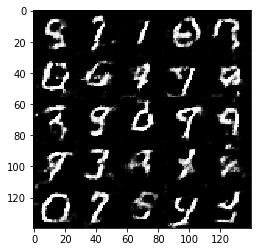

Epoch 0/2... Discriminator Loss: 1.1623... Generator Loss: 0.9071
Epoch 0/2... Discriminator Loss: 1.1667... Generator Loss: 0.9269
Epoch 0/2... Discriminator Loss: 1.3233... Generator Loss: 1.0011
Epoch 0/2... Discriminator Loss: 0.9690... Generator Loss: 2.1628
Epoch 0/2... Discriminator Loss: 1.1509... Generator Loss: 1.2218
Epoch 0/2... Discriminator Loss: 1.1786... Generator Loss: 1.6426
Epoch 0/2... Discriminator Loss: 1.2874... Generator Loss: 0.5386
Epoch 0/2... Discriminator Loss: 0.9954... Generator Loss: 1.1825
Epoch 0/2... Discriminator Loss: 1.0690... Generator Loss: 1.1611
Epoch 0/2... Discriminator Loss: 0.9502... Generator Loss: 1.4333


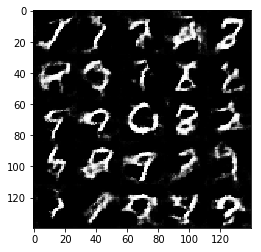

Epoch 0/2... Discriminator Loss: 1.7610... Generator Loss: 2.2185
Epoch 0/2... Discriminator Loss: 0.9405... Generator Loss: 1.2491
Epoch 0/2... Discriminator Loss: 1.3501... Generator Loss: 0.7692
Epoch 0/2... Discriminator Loss: 0.9576... Generator Loss: 0.9440
Epoch 0/2... Discriminator Loss: 1.0123... Generator Loss: 0.7286
Epoch 0/2... Discriminator Loss: 0.8594... Generator Loss: 1.4204
Epoch 0/2... Discriminator Loss: 0.9242... Generator Loss: 1.6362
Epoch 0/2... Discriminator Loss: 0.9856... Generator Loss: 1.7689
Epoch 0/2... Discriminator Loss: 0.9711... Generator Loss: 1.3487
Epoch 0/2... Discriminator Loss: 1.0812... Generator Loss: 0.8870


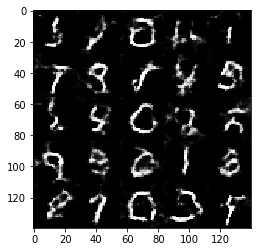

Epoch 0/2... Discriminator Loss: 0.9663... Generator Loss: 1.4427
Epoch 0/2... Discriminator Loss: 1.1675... Generator Loss: 0.7801
Epoch 0/2... Discriminator Loss: 0.9945... Generator Loss: 1.2112
Epoch 0/2... Discriminator Loss: 0.9702... Generator Loss: 0.9668
Epoch 0/2... Discriminator Loss: 0.8833... Generator Loss: 1.8295
Epoch 0/2... Discriminator Loss: 1.4274... Generator Loss: 0.9008
Epoch 0/2... Discriminator Loss: 1.0333... Generator Loss: 1.0526
Epoch 0/2... Discriminator Loss: 0.9421... Generator Loss: 1.5838
Epoch 0/2... Discriminator Loss: 0.8566... Generator Loss: 1.2265
Epoch 0/2... Discriminator Loss: 1.1398... Generator Loss: 0.7970


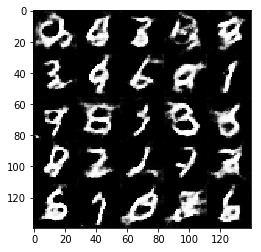

Epoch 0/2... Discriminator Loss: 1.2610... Generator Loss: 1.2110
Epoch 0/2... Discriminator Loss: 0.8602... Generator Loss: 1.7640
Epoch 0/2... Discriminator Loss: 0.9765... Generator Loss: 1.7109
Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.2960
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 1.2946
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 1.2622
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.6490
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.1665
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.9890
Epoch 1/2... Discriminator Loss: 1.0006... Generator Loss: 1.0419


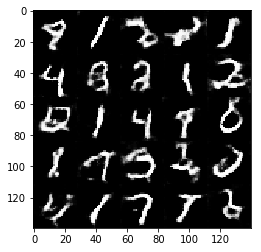

Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 1.3781
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 1.3893
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.3504
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 1.4358
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.7706
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 2.2141


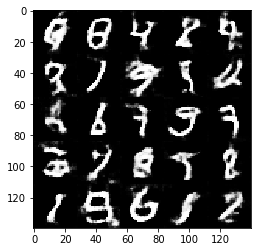

Epoch 1/2... Discriminator Loss: 1.9433... Generator Loss: 0.4196
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.5429
Epoch 1/2... Discriminator Loss: 0.8304... Generator Loss: 1.5685
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 1.0807
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.2034
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 1.6042
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.2259
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 1.9392
Epoch 1/2... Discriminator Loss: 0.7586... Generator Loss: 1.4278


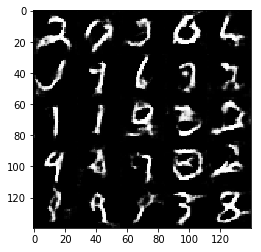

Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 2.1386
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 1.1012
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.1271... Generator Loss: 3.1600
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 1.9039
Epoch 1/2... Discriminator Loss: 0.6258... Generator Loss: 1.9973


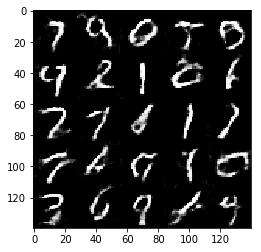

Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.3212
Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 1.5771
Epoch 1/2... Discriminator Loss: 0.9072... Generator Loss: 2.0855
Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 1.8716
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 1.5306
Epoch 1/2... Discriminator Loss: 0.7693... Generator Loss: 1.2989
Epoch 1/2... Discriminator Loss: 1.7674... Generator Loss: 0.4103
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 2.0855
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 1.2639
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 2.5060


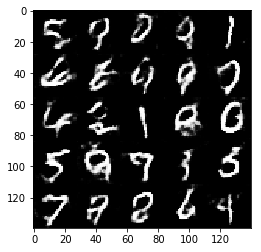

Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 1.5028
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 0.7105... Generator Loss: 1.6581
Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 1.6675
Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 2.1760
Epoch 1/2... Discriminator Loss: 0.7497... Generator Loss: 2.2834
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.6259


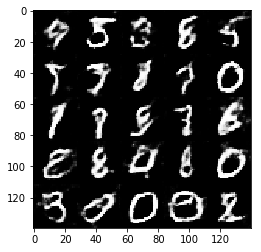

Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.5994
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.2657
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.6024
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.5021
Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.3065
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 3.3008


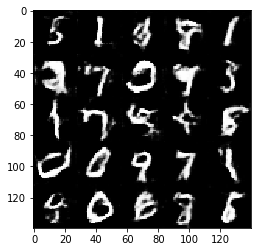

Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 1.9717
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 1.1874
Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 1.0178
Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.9818
Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 0.7053... Generator Loss: 1.3841
Epoch 1/2... Discriminator Loss: 1.0078... Generator Loss: 1.1328
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 2.2923
Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 1.6288


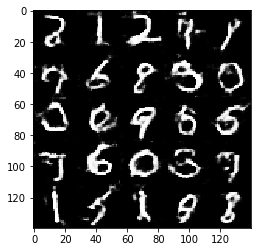

Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.4324
Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 1.0461
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 2.4878
Epoch 1/2... Discriminator Loss: 0.6897... Generator Loss: 1.6650
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 1.5100
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.5722
Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 1.6499
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.8439


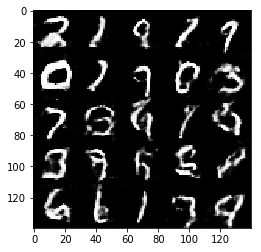

Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 1.3957
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.6482
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 1.3096
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 2.1724
Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 1.5954
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 2.8821


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.5049... Generator Loss: 2.6681
Epoch 0/1... Discriminator Loss: 0.5868... Generator Loss: 4.3372
Epoch 0/1... Discriminator Loss: 0.6716... Generator Loss: 1.5973
Epoch 0/1... Discriminator Loss: 0.9365... Generator Loss: 1.5046
Epoch 0/1... Discriminator Loss: 0.8553... Generator Loss: 1.7581
Epoch 0/1... Discriminator Loss: 0.5381... Generator Loss: 2.1071
Epoch 0/1... Discriminator Loss: 0.6580... Generator Loss: 1.5873
Epoch 0/1... Discriminator Loss: 0.8505... Generator Loss: 1.4932
Epoch 0/1... Discriminator Loss: 0.9706... Generator Loss: 0.9980
Epoch 0/1... Discriminator Loss: 0.8802... Generator Loss: 1.2377


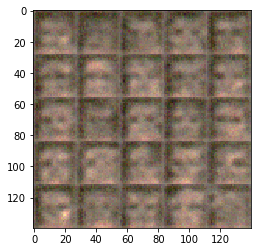

Epoch 0/1... Discriminator Loss: 0.6026... Generator Loss: 2.1660
Epoch 0/1... Discriminator Loss: 0.7853... Generator Loss: 1.6722
Epoch 0/1... Discriminator Loss: 0.9085... Generator Loss: 1.2296
Epoch 0/1... Discriminator Loss: 1.7181... Generator Loss: 2.8022
Epoch 0/1... Discriminator Loss: 1.0356... Generator Loss: 1.0142
Epoch 0/1... Discriminator Loss: 1.5938... Generator Loss: 0.3540
Epoch 0/1... Discriminator Loss: 1.1194... Generator Loss: 1.4979
Epoch 0/1... Discriminator Loss: 0.9419... Generator Loss: 1.2697
Epoch 0/1... Discriminator Loss: 2.2712... Generator Loss: 2.0678
Epoch 0/1... Discriminator Loss: 1.1808... Generator Loss: 0.7385


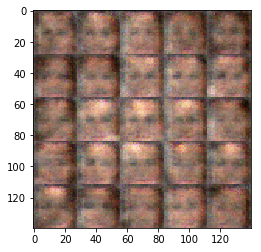

Epoch 0/1... Discriminator Loss: 1.0423... Generator Loss: 2.0096
Epoch 0/1... Discriminator Loss: 1.0169... Generator Loss: 0.9571
Epoch 0/1... Discriminator Loss: 1.1596... Generator Loss: 0.9060
Epoch 0/1... Discriminator Loss: 1.0103... Generator Loss: 1.2056
Epoch 0/1... Discriminator Loss: 0.7868... Generator Loss: 1.5862
Epoch 0/1... Discriminator Loss: 1.0763... Generator Loss: 1.1630
Epoch 0/1... Discriminator Loss: 0.7038... Generator Loss: 1.4275
Epoch 0/1... Discriminator Loss: 0.8346... Generator Loss: 1.7703
Epoch 0/1... Discriminator Loss: 0.8852... Generator Loss: 1.4148
Epoch 0/1... Discriminator Loss: 1.4915... Generator Loss: 0.6737


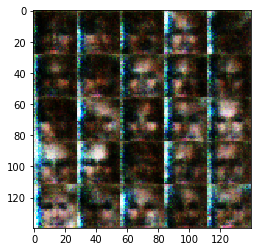

Epoch 0/1... Discriminator Loss: 1.1076... Generator Loss: 1.7285
Epoch 0/1... Discriminator Loss: 1.3056... Generator Loss: 0.6705
Epoch 0/1... Discriminator Loss: 0.7973... Generator Loss: 1.4227
Epoch 0/1... Discriminator Loss: 0.5938... Generator Loss: 1.5493
Epoch 0/1... Discriminator Loss: 1.3367... Generator Loss: 0.9394
Epoch 0/1... Discriminator Loss: 0.8530... Generator Loss: 1.4945
Epoch 0/1... Discriminator Loss: 0.9171... Generator Loss: 1.2235
Epoch 0/1... Discriminator Loss: 1.1974... Generator Loss: 1.2304
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 1.0315
Epoch 0/1... Discriminator Loss: 1.1835... Generator Loss: 0.8109


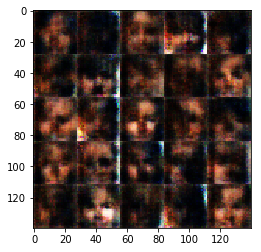

Epoch 0/1... Discriminator Loss: 1.0651... Generator Loss: 2.3765
Epoch 0/1... Discriminator Loss: 0.9736... Generator Loss: 1.5960
Epoch 0/1... Discriminator Loss: 0.7711... Generator Loss: 1.2239
Epoch 0/1... Discriminator Loss: 1.0567... Generator Loss: 2.4438
Epoch 0/1... Discriminator Loss: 0.6215... Generator Loss: 1.7728
Epoch 0/1... Discriminator Loss: 0.9673... Generator Loss: 1.3353
Epoch 0/1... Discriminator Loss: 0.9909... Generator Loss: 1.7641
Epoch 0/1... Discriminator Loss: 1.2926... Generator Loss: 1.1095
Epoch 0/1... Discriminator Loss: 1.2353... Generator Loss: 0.8029
Epoch 0/1... Discriminator Loss: 1.0215... Generator Loss: 0.9712


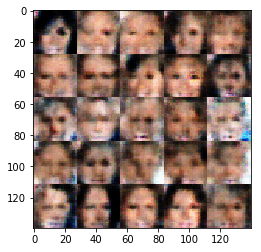

Epoch 0/1... Discriminator Loss: 1.1568... Generator Loss: 1.2931
Epoch 0/1... Discriminator Loss: 1.3613... Generator Loss: 1.3821
Epoch 0/1... Discriminator Loss: 0.9748... Generator Loss: 1.0745
Epoch 0/1... Discriminator Loss: 1.0477... Generator Loss: 1.6213
Epoch 0/1... Discriminator Loss: 1.2180... Generator Loss: 1.6292
Epoch 0/1... Discriminator Loss: 1.0369... Generator Loss: 1.4251
Epoch 0/1... Discriminator Loss: 1.1946... Generator Loss: 0.9681
Epoch 0/1... Discriminator Loss: 1.0587... Generator Loss: 1.3535
Epoch 0/1... Discriminator Loss: 0.7313... Generator Loss: 1.2357
Epoch 0/1... Discriminator Loss: 0.8791... Generator Loss: 1.1842


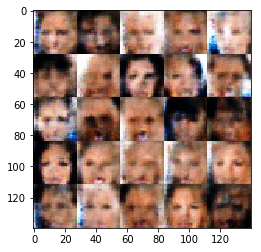

Epoch 0/1... Discriminator Loss: 1.0353... Generator Loss: 1.1015
Epoch 0/1... Discriminator Loss: 1.0140... Generator Loss: 0.9789
Epoch 0/1... Discriminator Loss: 1.2130... Generator Loss: 1.3219
Epoch 0/1... Discriminator Loss: 1.1450... Generator Loss: 1.4673
Epoch 0/1... Discriminator Loss: 0.9232... Generator Loss: 1.1188
Epoch 0/1... Discriminator Loss: 1.0025... Generator Loss: 1.6658
Epoch 0/1... Discriminator Loss: 1.2871... Generator Loss: 0.9748
Epoch 0/1... Discriminator Loss: 1.3209... Generator Loss: 0.9346
Epoch 0/1... Discriminator Loss: 1.1429... Generator Loss: 1.6122
Epoch 0/1... Discriminator Loss: 1.2818... Generator Loss: 0.8066


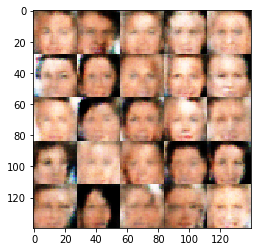

Epoch 0/1... Discriminator Loss: 0.9553... Generator Loss: 1.4830
Epoch 0/1... Discriminator Loss: 1.1859... Generator Loss: 0.8244
Epoch 0/1... Discriminator Loss: 1.2853... Generator Loss: 0.9722
Epoch 0/1... Discriminator Loss: 0.8653... Generator Loss: 1.2518
Epoch 0/1... Discriminator Loss: 1.2672... Generator Loss: 1.2387
Epoch 0/1... Discriminator Loss: 1.3645... Generator Loss: 0.6259
Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 1.3143
Epoch 0/1... Discriminator Loss: 1.2593... Generator Loss: 0.6654
Epoch 0/1... Discriminator Loss: 1.4124... Generator Loss: 2.1375
Epoch 0/1... Discriminator Loss: 1.1118... Generator Loss: 0.7859


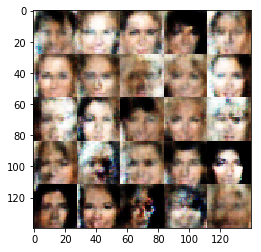

Epoch 0/1... Discriminator Loss: 1.0946... Generator Loss: 0.9085
Epoch 0/1... Discriminator Loss: 1.1881... Generator Loss: 0.7047
Epoch 0/1... Discriminator Loss: 0.9448... Generator Loss: 1.3309
Epoch 0/1... Discriminator Loss: 0.8409... Generator Loss: 1.5494
Epoch 0/1... Discriminator Loss: 1.5499... Generator Loss: 0.5428
Epoch 0/1... Discriminator Loss: 1.0248... Generator Loss: 1.3159
Epoch 0/1... Discriminator Loss: 0.9785... Generator Loss: 0.9959
Epoch 0/1... Discriminator Loss: 1.0682... Generator Loss: 1.2656
Epoch 0/1... Discriminator Loss: 1.0824... Generator Loss: 0.8127
Epoch 0/1... Discriminator Loss: 1.3668... Generator Loss: 0.8716


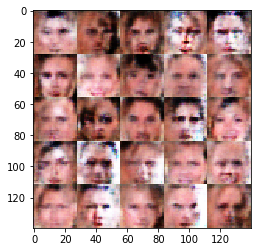

Epoch 0/1... Discriminator Loss: 1.6135... Generator Loss: 1.0174
Epoch 0/1... Discriminator Loss: 1.2595... Generator Loss: 1.2135
Epoch 0/1... Discriminator Loss: 1.0537... Generator Loss: 0.9656
Epoch 0/1... Discriminator Loss: 1.0953... Generator Loss: 1.0042
Epoch 0/1... Discriminator Loss: 0.8491... Generator Loss: 1.3725
Epoch 0/1... Discriminator Loss: 1.1501... Generator Loss: 1.1924
Epoch 0/1... Discriminator Loss: 1.1229... Generator Loss: 1.2050
Epoch 0/1... Discriminator Loss: 1.0267... Generator Loss: 1.1635
Epoch 0/1... Discriminator Loss: 1.1440... Generator Loss: 0.7330
Epoch 0/1... Discriminator Loss: 1.1953... Generator Loss: 1.0934


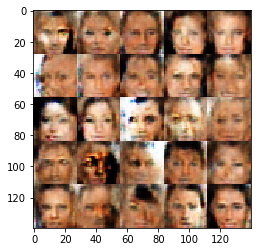

Epoch 0/1... Discriminator Loss: 1.2638... Generator Loss: 0.7887
Epoch 0/1... Discriminator Loss: 1.1732... Generator Loss: 0.8326
Epoch 0/1... Discriminator Loss: 1.0059... Generator Loss: 1.1142
Epoch 0/1... Discriminator Loss: 1.0222... Generator Loss: 0.9947
Epoch 0/1... Discriminator Loss: 1.2917... Generator Loss: 0.7881
Epoch 0/1... Discriminator Loss: 1.1405... Generator Loss: 1.2996
Epoch 0/1... Discriminator Loss: 1.3483... Generator Loss: 0.8808
Epoch 0/1... Discriminator Loss: 1.2942... Generator Loss: 0.7640
Epoch 0/1... Discriminator Loss: 0.8969... Generator Loss: 1.0581
Epoch 0/1... Discriminator Loss: 1.1903... Generator Loss: 0.8444


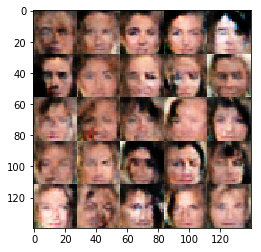

Epoch 0/1... Discriminator Loss: 1.2747... Generator Loss: 0.7751
Epoch 0/1... Discriminator Loss: 1.0186... Generator Loss: 1.1965
Epoch 0/1... Discriminator Loss: 1.2384... Generator Loss: 1.1660
Epoch 0/1... Discriminator Loss: 1.0758... Generator Loss: 1.8291
Epoch 0/1... Discriminator Loss: 1.1674... Generator Loss: 1.0132
Epoch 0/1... Discriminator Loss: 0.8647... Generator Loss: 1.4602
Epoch 0/1... Discriminator Loss: 1.1176... Generator Loss: 0.9302
Epoch 0/1... Discriminator Loss: 1.1668... Generator Loss: 0.9708
Epoch 0/1... Discriminator Loss: 0.9541... Generator Loss: 1.1859
Epoch 0/1... Discriminator Loss: 1.1519... Generator Loss: 0.9556


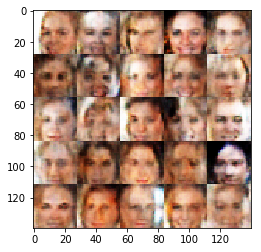

Epoch 0/1... Discriminator Loss: 1.1180... Generator Loss: 1.0501
Epoch 0/1... Discriminator Loss: 1.0910... Generator Loss: 0.9820
Epoch 0/1... Discriminator Loss: 1.1678... Generator Loss: 1.0198
Epoch 0/1... Discriminator Loss: 1.1211... Generator Loss: 1.0166
Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 1.1054
Epoch 0/1... Discriminator Loss: 1.0458... Generator Loss: 0.9193
Epoch 0/1... Discriminator Loss: 1.0138... Generator Loss: 1.0720
Epoch 0/1... Discriminator Loss: 1.0816... Generator Loss: 0.9137
Epoch 0/1... Discriminator Loss: 1.0892... Generator Loss: 0.8323
Epoch 0/1... Discriminator Loss: 1.3594... Generator Loss: 1.0207


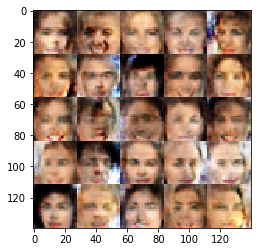

Epoch 0/1... Discriminator Loss: 1.3886... Generator Loss: 1.0359
Epoch 0/1... Discriminator Loss: 1.1872... Generator Loss: 0.7835
Epoch 0/1... Discriminator Loss: 1.0888... Generator Loss: 0.9489
Epoch 0/1... Discriminator Loss: 1.0725... Generator Loss: 0.9161
Epoch 0/1... Discriminator Loss: 1.1384... Generator Loss: 0.7872
Epoch 0/1... Discriminator Loss: 1.0676... Generator Loss: 1.1170
Epoch 0/1... Discriminator Loss: 1.1496... Generator Loss: 1.1006
Epoch 0/1... Discriminator Loss: 1.1525... Generator Loss: 0.8457
Epoch 0/1... Discriminator Loss: 1.2732... Generator Loss: 0.5632
Epoch 0/1... Discriminator Loss: 0.8624... Generator Loss: 1.2731


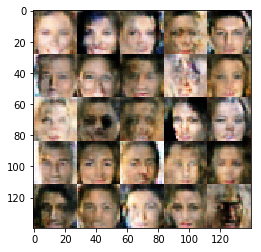

Epoch 0/1... Discriminator Loss: 1.0882... Generator Loss: 1.0550
Epoch 0/1... Discriminator Loss: 1.1716... Generator Loss: 0.8640
Epoch 0/1... Discriminator Loss: 1.1585... Generator Loss: 0.8348
Epoch 0/1... Discriminator Loss: 1.1844... Generator Loss: 1.0349
Epoch 0/1... Discriminator Loss: 1.2605... Generator Loss: 1.0363
Epoch 0/1... Discriminator Loss: 1.0355... Generator Loss: 1.1444
Epoch 0/1... Discriminator Loss: 1.1944... Generator Loss: 1.0814
Epoch 0/1... Discriminator Loss: 1.0309... Generator Loss: 1.0766
Epoch 0/1... Discriminator Loss: 0.9348... Generator Loss: 0.8986
Epoch 0/1... Discriminator Loss: 1.0605... Generator Loss: 1.1736


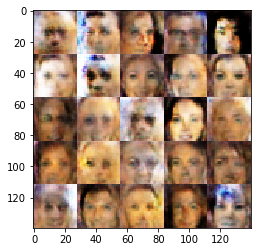

Epoch 0/1... Discriminator Loss: 1.2815... Generator Loss: 0.8560
Epoch 0/1... Discriminator Loss: 1.4969... Generator Loss: 0.7464
Epoch 0/1... Discriminator Loss: 1.2674... Generator Loss: 0.9493
Epoch 0/1... Discriminator Loss: 1.1081... Generator Loss: 0.8263
Epoch 0/1... Discriminator Loss: 1.4244... Generator Loss: 0.8099
Epoch 0/1... Discriminator Loss: 0.9751... Generator Loss: 1.0739
Epoch 0/1... Discriminator Loss: 0.9815... Generator Loss: 1.3537
Epoch 0/1... Discriminator Loss: 1.2735... Generator Loss: 0.6678
Epoch 0/1... Discriminator Loss: 1.0365... Generator Loss: 0.9485
Epoch 0/1... Discriminator Loss: 1.0899... Generator Loss: 1.1897


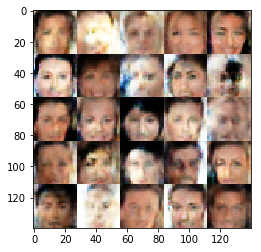

Epoch 0/1... Discriminator Loss: 1.0914... Generator Loss: 1.2357
Epoch 0/1... Discriminator Loss: 1.1087... Generator Loss: 1.3021
Epoch 0/1... Discriminator Loss: 1.1576... Generator Loss: 0.7286
Epoch 0/1... Discriminator Loss: 1.0044... Generator Loss: 0.9887
Epoch 0/1... Discriminator Loss: 1.1212... Generator Loss: 0.9518
Epoch 0/1... Discriminator Loss: 1.1565... Generator Loss: 1.0270
Epoch 0/1... Discriminator Loss: 1.3213... Generator Loss: 0.8482
Epoch 0/1... Discriminator Loss: 1.0095... Generator Loss: 0.7960
Epoch 0/1... Discriminator Loss: 1.0291... Generator Loss: 1.0465
Epoch 0/1... Discriminator Loss: 0.9928... Generator Loss: 0.9697


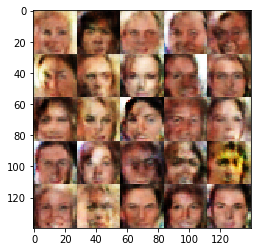

Epoch 0/1... Discriminator Loss: 1.1322... Generator Loss: 0.9415
Epoch 0/1... Discriminator Loss: 1.1224... Generator Loss: 0.8354
Epoch 0/1... Discriminator Loss: 0.9794... Generator Loss: 1.1608
Epoch 0/1... Discriminator Loss: 0.9876... Generator Loss: 1.6611
Epoch 0/1... Discriminator Loss: 1.0215... Generator Loss: 1.3463
Epoch 0/1... Discriminator Loss: 1.0983... Generator Loss: 0.9065
Epoch 0/1... Discriminator Loss: 1.0149... Generator Loss: 1.4024
Epoch 0/1... Discriminator Loss: 1.2295... Generator Loss: 0.8960
Epoch 0/1... Discriminator Loss: 1.1746... Generator Loss: 1.1009
Epoch 0/1... Discriminator Loss: 1.0908... Generator Loss: 1.1550


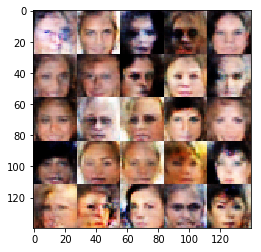

Epoch 0/1... Discriminator Loss: 1.2682... Generator Loss: 1.5664
Epoch 0/1... Discriminator Loss: 1.0786... Generator Loss: 0.9701
Epoch 0/1... Discriminator Loss: 1.3775... Generator Loss: 0.5860
Epoch 0/1... Discriminator Loss: 1.0361... Generator Loss: 0.8204
Epoch 0/1... Discriminator Loss: 1.0300... Generator Loss: 1.2245
Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 1.0786
Epoch 0/1... Discriminator Loss: 1.0633... Generator Loss: 1.1159
Epoch 0/1... Discriminator Loss: 1.1904... Generator Loss: 1.6858
Epoch 0/1... Discriminator Loss: 0.9178... Generator Loss: 1.1880
Epoch 0/1... Discriminator Loss: 0.9173... Generator Loss: 1.3332


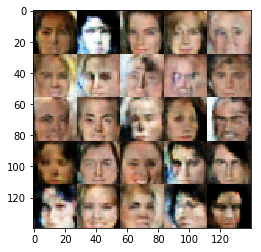

Epoch 0/1... Discriminator Loss: 1.2716... Generator Loss: 1.1010
Epoch 0/1... Discriminator Loss: 1.0660... Generator Loss: 1.1243
Epoch 0/1... Discriminator Loss: 0.8606... Generator Loss: 1.4255
Epoch 0/1... Discriminator Loss: 1.0357... Generator Loss: 1.4778
Epoch 0/1... Discriminator Loss: 1.1438... Generator Loss: 1.1764
Epoch 0/1... Discriminator Loss: 1.0454... Generator Loss: 1.0066
Epoch 0/1... Discriminator Loss: 0.9382... Generator Loss: 1.3374
Epoch 0/1... Discriminator Loss: 0.9811... Generator Loss: 1.1662
Epoch 0/1... Discriminator Loss: 1.0892... Generator Loss: 0.6276
Epoch 0/1... Discriminator Loss: 1.1896... Generator Loss: 0.9016


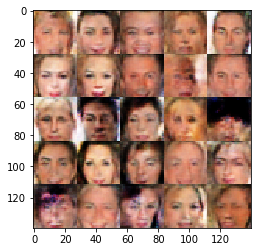

Epoch 0/1... Discriminator Loss: 1.4035... Generator Loss: 0.5660
Epoch 0/1... Discriminator Loss: 0.9895... Generator Loss: 1.2042
Epoch 0/1... Discriminator Loss: 1.0984... Generator Loss: 0.8842
Epoch 0/1... Discriminator Loss: 1.1602... Generator Loss: 1.0458
Epoch 0/1... Discriminator Loss: 1.4317... Generator Loss: 0.8997
Epoch 0/1... Discriminator Loss: 1.2254... Generator Loss: 1.2163
Epoch 0/1... Discriminator Loss: 0.9827... Generator Loss: 1.1310
Epoch 0/1... Discriminator Loss: 0.9819... Generator Loss: 1.1855
Epoch 0/1... Discriminator Loss: 0.9261... Generator Loss: 0.9228
Epoch 0/1... Discriminator Loss: 0.9353... Generator Loss: 0.7611


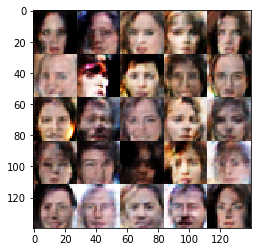

Epoch 0/1... Discriminator Loss: 1.0100... Generator Loss: 1.2278
Epoch 0/1... Discriminator Loss: 1.1089... Generator Loss: 1.4100
Epoch 0/1... Discriminator Loss: 1.1243... Generator Loss: 1.6166
Epoch 0/1... Discriminator Loss: 1.0869... Generator Loss: 1.1547
Epoch 0/1... Discriminator Loss: 1.1089... Generator Loss: 1.0555
Epoch 0/1... Discriminator Loss: 1.2540... Generator Loss: 1.0805
Epoch 0/1... Discriminator Loss: 1.0498... Generator Loss: 1.0286
Epoch 0/1... Discriminator Loss: 1.3350... Generator Loss: 0.5870
Epoch 0/1... Discriminator Loss: 1.3444... Generator Loss: 0.9144
Epoch 0/1... Discriminator Loss: 1.3015... Generator Loss: 0.9429


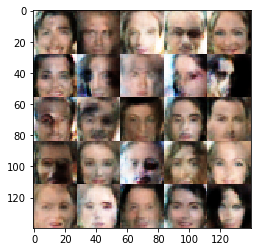

Epoch 0/1... Discriminator Loss: 0.8952... Generator Loss: 0.9674
Epoch 0/1... Discriminator Loss: 1.1327... Generator Loss: 1.0465
Epoch 0/1... Discriminator Loss: 1.2717... Generator Loss: 0.8590
Epoch 0/1... Discriminator Loss: 1.2295... Generator Loss: 0.7054
Epoch 0/1... Discriminator Loss: 1.1111... Generator Loss: 1.2477
Epoch 0/1... Discriminator Loss: 1.4220... Generator Loss: 1.0206
Epoch 0/1... Discriminator Loss: 1.1346... Generator Loss: 0.8671
Epoch 0/1... Discriminator Loss: 0.9675... Generator Loss: 1.3743
Epoch 0/1... Discriminator Loss: 1.1618... Generator Loss: 0.8196
Epoch 0/1... Discriminator Loss: 1.1058... Generator Loss: 1.8215


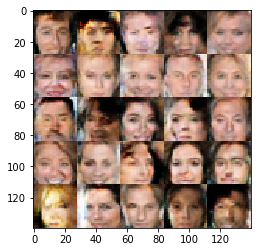

Epoch 0/1... Discriminator Loss: 1.1638... Generator Loss: 0.8572
Epoch 0/1... Discriminator Loss: 1.0241... Generator Loss: 0.9084
Epoch 0/1... Discriminator Loss: 1.0386... Generator Loss: 1.2908
Epoch 0/1... Discriminator Loss: 1.1667... Generator Loss: 1.1112
Epoch 0/1... Discriminator Loss: 1.0643... Generator Loss: 1.0304
Epoch 0/1... Discriminator Loss: 1.3377... Generator Loss: 0.9147
Epoch 0/1... Discriminator Loss: 1.1310... Generator Loss: 1.0002
Epoch 0/1... Discriminator Loss: 1.2770... Generator Loss: 0.8305
Epoch 0/1... Discriminator Loss: 1.0301... Generator Loss: 1.1202
Epoch 0/1... Discriminator Loss: 0.9687... Generator Loss: 0.9595


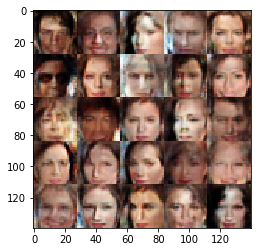

Epoch 0/1... Discriminator Loss: 1.2431... Generator Loss: 1.2925
Epoch 0/1... Discriminator Loss: 1.0751... Generator Loss: 0.9776
Epoch 0/1... Discriminator Loss: 1.2458... Generator Loss: 0.9871
Epoch 0/1... Discriminator Loss: 1.0815... Generator Loss: 0.9016
Epoch 0/1... Discriminator Loss: 1.1889... Generator Loss: 1.1240
Epoch 0/1... Discriminator Loss: 1.0861... Generator Loss: 0.6785
Epoch 0/1... Discriminator Loss: 1.1345... Generator Loss: 1.6295
Epoch 0/1... Discriminator Loss: 1.2761... Generator Loss: 1.0760
Epoch 0/1... Discriminator Loss: 0.9977... Generator Loss: 1.2390
Epoch 0/1... Discriminator Loss: 1.2693... Generator Loss: 1.0715


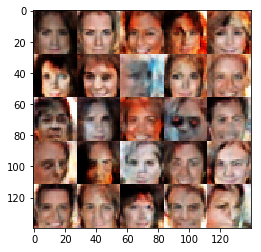

Epoch 0/1... Discriminator Loss: 1.1249... Generator Loss: 1.2375
Epoch 0/1... Discriminator Loss: 1.3007... Generator Loss: 1.1310
Epoch 0/1... Discriminator Loss: 1.1172... Generator Loss: 1.1561
Epoch 0/1... Discriminator Loss: 0.9590... Generator Loss: 0.8146
Epoch 0/1... Discriminator Loss: 0.9820... Generator Loss: 1.1214
Epoch 0/1... Discriminator Loss: 0.9207... Generator Loss: 0.7847
Epoch 0/1... Discriminator Loss: 1.0991... Generator Loss: 1.1347
Epoch 0/1... Discriminator Loss: 1.1283... Generator Loss: 1.3911
Epoch 0/1... Discriminator Loss: 1.2203... Generator Loss: 0.9841
Epoch 0/1... Discriminator Loss: 1.0902... Generator Loss: 1.2924


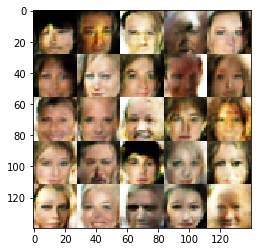

Epoch 0/1... Discriminator Loss: 1.0421... Generator Loss: 0.8614
Epoch 0/1... Discriminator Loss: 1.2817... Generator Loss: 1.2715
Epoch 0/1... Discriminator Loss: 1.1190... Generator Loss: 1.1227
Epoch 0/1... Discriminator Loss: 1.0769... Generator Loss: 0.9185
Epoch 0/1... Discriminator Loss: 1.2073... Generator Loss: 1.1330
Epoch 0/1... Discriminator Loss: 1.0441... Generator Loss: 1.3849
Epoch 0/1... Discriminator Loss: 0.9802... Generator Loss: 1.3017
Epoch 0/1... Discriminator Loss: 1.0971... Generator Loss: 1.2174
Epoch 0/1... Discriminator Loss: 1.2248... Generator Loss: 0.9372
Epoch 0/1... Discriminator Loss: 1.2896... Generator Loss: 0.8295


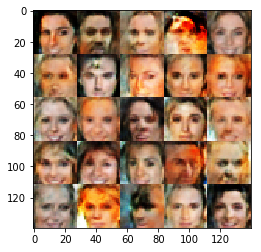

Epoch 0/1... Discriminator Loss: 1.1552... Generator Loss: 1.1448
Epoch 0/1... Discriminator Loss: 1.1783... Generator Loss: 1.0924
Epoch 0/1... Discriminator Loss: 1.3015... Generator Loss: 0.5578
Epoch 0/1... Discriminator Loss: 1.0177... Generator Loss: 0.9482
Epoch 0/1... Discriminator Loss: 1.3514... Generator Loss: 1.1455
Epoch 0/1... Discriminator Loss: 1.0406... Generator Loss: 1.0578
Epoch 0/1... Discriminator Loss: 1.3113... Generator Loss: 0.8297
Epoch 0/1... Discriminator Loss: 1.0222... Generator Loss: 0.9742
Epoch 0/1... Discriminator Loss: 1.1252... Generator Loss: 1.5111
Epoch 0/1... Discriminator Loss: 1.1864... Generator Loss: 0.8330


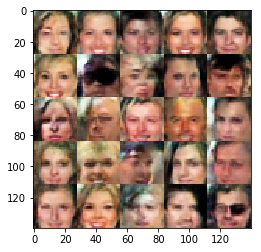

Epoch 0/1... Discriminator Loss: 1.0564... Generator Loss: 0.6814
Epoch 0/1... Discriminator Loss: 1.2198... Generator Loss: 0.5077
Epoch 0/1... Discriminator Loss: 1.1350... Generator Loss: 0.8508
Epoch 0/1... Discriminator Loss: 1.0404... Generator Loss: 1.0935
Epoch 0/1... Discriminator Loss: 1.1140... Generator Loss: 0.8161
Epoch 0/1... Discriminator Loss: 1.0056... Generator Loss: 1.1930
Epoch 0/1... Discriminator Loss: 1.4256... Generator Loss: 0.7130
Epoch 0/1... Discriminator Loss: 1.0295... Generator Loss: 0.7410
Epoch 0/1... Discriminator Loss: 1.1019... Generator Loss: 0.6922
Epoch 0/1... Discriminator Loss: 1.0462... Generator Loss: 0.9046


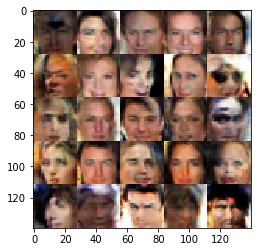

Epoch 0/1... Discriminator Loss: 1.1166... Generator Loss: 0.9419
Epoch 0/1... Discriminator Loss: 1.2672... Generator Loss: 0.7754
Epoch 0/1... Discriminator Loss: 1.2690... Generator Loss: 1.4057
Epoch 0/1... Discriminator Loss: 1.0814... Generator Loss: 1.4321
Epoch 0/1... Discriminator Loss: 1.0925... Generator Loss: 0.8858
Epoch 0/1... Discriminator Loss: 1.2029... Generator Loss: 1.2854
Epoch 0/1... Discriminator Loss: 0.9137... Generator Loss: 1.2980
Epoch 0/1... Discriminator Loss: 1.2997... Generator Loss: 1.3910
Epoch 0/1... Discriminator Loss: 1.3770... Generator Loss: 1.0978
Epoch 0/1... Discriminator Loss: 1.1161... Generator Loss: 0.7232


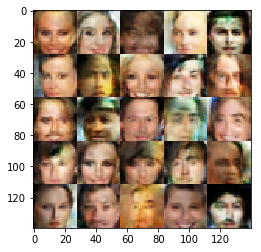

Epoch 0/1... Discriminator Loss: 1.1141... Generator Loss: 1.2108
Epoch 0/1... Discriminator Loss: 1.2922... Generator Loss: 0.7763
Epoch 0/1... Discriminator Loss: 1.2645... Generator Loss: 0.6922
Epoch 0/1... Discriminator Loss: 1.2295... Generator Loss: 0.8203
Epoch 0/1... Discriminator Loss: 1.1877... Generator Loss: 0.8580
Epoch 0/1... Discriminator Loss: 1.0445... Generator Loss: 0.9969
Epoch 0/1... Discriminator Loss: 1.2161... Generator Loss: 1.1746
Epoch 0/1... Discriminator Loss: 0.9854... Generator Loss: 0.9798
Epoch 0/1... Discriminator Loss: 1.2154... Generator Loss: 0.8405
Epoch 0/1... Discriminator Loss: 1.1760... Generator Loss: 1.0054


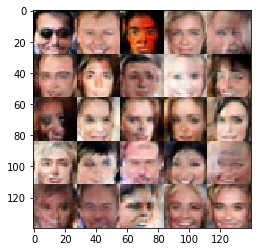

Epoch 0/1... Discriminator Loss: 1.1205... Generator Loss: 0.9032
Epoch 0/1... Discriminator Loss: 1.2461... Generator Loss: 1.0936
Epoch 0/1... Discriminator Loss: 1.3160... Generator Loss: 0.7721
Epoch 0/1... Discriminator Loss: 1.3205... Generator Loss: 0.9456
Epoch 0/1... Discriminator Loss: 1.2465... Generator Loss: 1.0974
Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 1.0786


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.